# Auto-Stitching Photo Mosaics
## Part 1: IMAGE WARPING and MOSAICING

The goal of this assignment is to get your hands dirty in different aspects of image warping with a “cool” application -- image mosaicing. You will take two or more photographs and create an image mosaic by registering, projective warping, resampling, and compositing them. Along the way, you will learn how to compute homographies, and how to use them to warp images.

 

The steps of the assignment are:

- Shoot and digitize pictures (20 pts)
- Recover homographies (20 pts)
- Warp the images (20 pts) [produce at least two examples of rectified images]
- Blend images into a mosaic (20 pts) [show source images and results for three mosaics.]
- optional Bells and Whistles (up to 20 pts, combined from Parts A and B)
- Submit your results
 

 

There are some built in functions that are able to do much of what is needed. However, we want you to write your own code. Therefore, you are not allowed to use the following functions in your solution: cp2tform, imtransform, tformarray, tformfwd, tforminv, and maketform, or their python equivalents. On the other hand, there are a number of very helpful functions (e.g. for solving linear systems, inverting matrices, linear interpolation, etc) that you are welcome to use. If there is a question whether a particular function is allowed, ask us.



 

### Shoot the pictures

Shoot two or more photographs so that the transforms between them are projective (a.k.a. perspective). One way to do this is to shoot from the same point of view but with different view directions, and with overlapping fields of view. Another way to do this is to shoot pictures of a planar surface (e.g. a wall) or a very far away scene (i.e. plane at infinity) from different points of view.

 

The easiest way to acquire pictures is using a digital camera. Make sure to use the highest resolution setting (important for homography calculation; you can always downsample it later). Matlab’s imread can take most popular image formats; use unix convert for the more obscure ones.

 

While we expect you to acquire most of the data yourself, you are free to supplement it with other sources (old photographs, scanned images, the Internet). We're not particular about how you take your pictures or get them into the computer, but we recommend:

- Avoid fisheye lenses or lenses with significant barrel distortion (do straight lines come out straight?). Any focal length is ok in principle, but wide angle lenses often make more interesting mosaics.
- Shoot as close together in time as possible, so your subjects don't move on you, and lighting doesn't change too much (unless you want this effect for artistic reasons).
- Use identical aperture & exposure settings, if possible. On most "idiot cameras" you don't have control of this, unfortunately. It's nice to use identical exposures so that the images will have identical brightness in the overlap region.
- You can use your smartphone camera, but please make sure the camera setting does not change. To do this, you can use exposure and focus locking (AE/AF) (e.g. in iPhone, you can press and hold to do this). You can also use a camera app. Please check the EXIF data of the photos once they are taken.
- Overlap the fields of view significantly. 40% to 70% overlap is recommended. Too little overlap makes registration harder.
- It's OK to vary the zoom (change focal length) between pictures.
- If you're shooting a non-planar scene, then shoot pictures from the same position (turn camera, but don't translate it). A tripod can help in this, particularly if objects are close.
- Good scenes are: building interiors with lots of detail, inside a canyon or forest, tall waterfalls, panoramas. The mosaic can extend horizontally, vertically, or can tile a sphere. You might want to shoot several such image sets and choose the best.

Shoot and digitize your pictures early - leave time to re-shoot in case they don't come out!

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread as r
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
backyard = np.rot90(r('backyard_1.jpg'), 3), np.rot90(r('backyard_2.jpg'),3), np.rot90(r('backyard_3.jpg'),3),\
np.rot90(r('backyard_4.jpg'),3), np.rot90(r('backyard_5.jpg'),3), np.rot90(r('backyard_6.jpg'),3)

fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(2, 3),  # creates 2x2 grid of axes
                 axes_pad=0.1,  # pad between axes in inch.
                 )

for ax, im in zip(grid, backyard):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)

In [4]:
#defining corrosponding points
one_to_two = np.array([[38.776, 24.783, 37.637, 29.536 ],
                       [46.389, 36.380, 35.530, 46.667]]) * 72

two_from_one = np.array([[15.772, 2.223, 15.582, 5.792],
                         [44.154, 36.121, 34.249, 46.133]])* 72
#72 is constant from pixels/inch according to photoshop
#im going to start with just connecting 2 images and come back to the other stuff later

### Recover Homographies
Before you can warp your images into alignment, you need to recover the parameters of the transformation between each pair of images. In our case, the transformation is a homography: p’=Hp, where H is a 3x3 matrix with 8 degrees of freedom (lower right corner is a scaling factor and can be set to 1). One way to recover the homography is via a set of (p’,p) pairs of corresponding points taken from the two images. You will need to write a function of the form:

 

`H = computeH(im1_pts,im2_pts)`

 

where im1_pts and im2_pts are n-by-2 matrices holding the (x,y) locations of n point correspondences from the two images and H is the recovered 3x3 homography matrix. In order to compute the entries in the matrix H, you will need to set up a linear system of n equations (i.e. a matrix equation of the form Ah=b where h is a vector holding the 8 unknown entries of H). If n=4, the system can be solved using a standard technique. However, with only four points, the homography recovery will be very unstable and prone to noise. Therefore more than 4 correspondences should be provided producing an overdetermined system which should be solved using least-squares. In Matlab, both operations can be performed using the “\” operator (see help mldivide for details).

 

Establishing point correspondences is a tricky business. An error of a couple of pixels can produce huge changes in the recovered homography. The typical way of providing point matches is with a mouse-clicking interface. You can write your own using the bare-bones ginput function. Or you can use a nifty (but often flaky). You can also use tools like Gimp or Photoshop to read off the pixel coordinates of the mouse cursor. cpselect. After defining the correspondences by hand, it’s often useful to fine-tune them automatically. This can be done by SSD or normalized-correlation matching of the patches surrounding the clicked points in the two images (see cpcorr), although sometimes it can produce undesirable results.

In [5]:
def get_coder(img_points):
    temp = np.stack([img_points[0,:3], img_points[1,:3], [1,1,1]], axis=0)
    inv = np.linalg.inv(temp)
    l, m, t =  inv @ np.array([img_points[0, 3], img_points[1, 3], 1]).T
    return np.multiply(temp, [l,m,t])

def computeH(img1_pts, img2_pts):
    a = get_coder(img1_pts)
    b = get_coder(img2_pts)
    return b@np.linalg.inv(a)

In [6]:
print(one_to_two.shape, two_from_one.shape)
computeH(one_to_two, two_from_one)

(2, 4) (2, 4)


array([[ 1.22966539e+00, -2.30791700e-01, -1.42250693e+03],
       [ 2.45200298e-01,  7.04303724e-01,  4.33657592e+02],
       [ 1.34168405e-04, -1.21848280e-04,  1.12409169e+00]])

### Warp the Images

 

Now that you know the parameters of the homography, you need to warp your images using this homography. Write a function of the form:

 

`imwarped = warpImage(im,H)`

 

where im is the input image to be warped and H is the homography. You can use either forward of inverse warping (but remember that for inverse warping you will need to compute H in the right “direction”). You will need to avoid aliasing when resampling the image. Consider using interp2, and see if you can write the whole function without any loops, Matlab-style. One thing you need to pay attention to is the size of the resulting image (you can predict the bounding box by piping the four corners of the image through H, or use extra input parameters). Also pay attention to how you mark pixels which don’t have any values. Consider using an alpha mask (or alpha channel) here.

In [ ]:
def projective(x,y,h):
    h = h.reshape((-1))
    z = h[6] *x  + h[7] * y + h[8]
    new_x = (h[0] * x + h[1] * y + h[2]) / z
    new_y = (h[3] * x + h[4] * y + h[5]) / z
    return new_x, new_y


In [36]:
#t= warp_image(backyard[0], computeH(one_to_two, two_from_one))[0]
from skimage.transform import warp
t2 = warp_image(backyard[0],np.linalg.inv(computeH(one_to_two, two_from_one)))
plt.imshow(t2[0])

NameError: name 'convert_to_float' is not defined

### Image Rectification

 

Once you get this far, you should be able to “rectify” an image. Take a few sample images with some planar surfaces, and warp them so that the plane is frontal-parallel (e.g. the night street examples above). You should do this before proceeding further to make sure your homography/warping is working. Note that since here you only have one image and need to compute a homography for, say, ground plane rectification (rotating the camera to point downward), you will need to define the correspondences using something you know about the image. E.g. if you know that the tiles on the floor are square, you can click on the four corners of a tile and store them in im1_pts while im2_pts you define by hand to be a square, e.g. [0 0; 0 1; 1 0; 1 1].

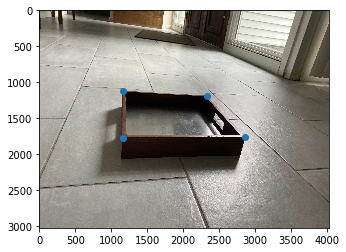

In [19]:
rect_test = plt.imread('square_thing.jpg')
corners = np.array([[16.123, 16.167, 32.346, 39.760],
                    [24.578, 15.628, 16.532, 24.516]])*72
plt.imshow(rect_test)
plt.scatter(corners[0], corners[1]);

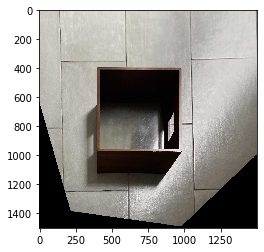

In [33]:
new_points = np.array([[16, 16, 24, 24],
                       [24, 16, 16, 24]])*72
rect_homo = computeH(corners, new_points)
rectified = warp(rect_test, np.linalg.inv(computeH(corners, new_points)), output_shape=rect_test.shape)
cropped = rectified[750:2250,750:2250,:]
plt.imshow(cropped)

In [39]:
plt.imsave('rectified.jpg', cropped)

 

### Blend the images into a mosaic

 

Warp the images so they're registered and create an image mosaic. Instead of having one picture overwrite the other, which would lead to strong edge artifacts, use weighted averaging. You can leave one image unwarped and warp the other image(s) into its projection, or you can warp all images into a new projection. Likewise, you can either warp all the images at once in one shot, or add them one by one, slowly growing your mosaic.

 

If you choose the one-shot procedure, you should probably first determine the size of your final mosaic and then warp all your images into that size. That way you will have a stack of images together defining the mosaic. Now you need to blend them together to produce a single image. If you used an alpha channel, you can apply simple feathering (weighted averaging) at every pixel. Setting alpha for each image takes some thought. One suggestion is to set it to 1 at the center of each (unwarped) image and make it fall off linearly until it hits 0 at the edges (or use the distance transform bwdist). However, this can produce some strange wedge-like artifacts. You can try minimizing these by using a more sophisticated blending technique, such as a Laplacian pyramid. If your only problem is “ghosting” of high-frequency terms, then a 2-level pyramid should be enough.

 

If your mosaic spans more than 180 degrees, you'll need to break it into pieces, or else use non-projective mappings, e.g. spherical or cylindrical projection.

In [81]:
output_shape = (backyard[0].shape[0]*1.5, backyard[0].shape[1]*3)
img_1 = warp(backyard[0], np.linalg.inv(computeH(one_to_two, two_from_one)), output_shape=output_shape)
img_2 = warp(backyard[1], np.linalg.inv(computeH(two_from_one, two_from_one)), output_shape=output_shape)


Tell us what you've learned

 

Whats the most important/coolest thing you have learned from this part?